In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import defaultdict

from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import PoissonRegressor, Lasso

from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

from typing import List, Callable

import _pickle as cpickle

import pathlib
figPath=pathlib.Path("figs")
figPath.mkdir(parents=True, exist_ok=True)
from pathlib import Path
#


In [3]:
try:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg
    from skforecast.model_selection import grid_search_forecaster
    from skforecast.model_selection import backtesting_forecaster
    import xgboost as xgb
except:
    !pip install --quiet skforecast
    !pip install --quiet xgboost
    from skforecast.ForecasterAutoreg import ForecasterAutoreg
    from skforecast.model_selection import backtesting_forecaster
    from skforecast.model_selection import grid_search_forecaster
    import xgboost as xgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.0/217.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 12.7 MB/s eta 0:00:00


In [4]:
!pip install --quiet matplotlib==3.1.3
#
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.size"]=14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 37.8 MB/s eta 0:00:00


In [6]:
path= "./drive/MyDrive/Ep/Marton_project"

In [49]:
def read_data(path):
    num_contact= pd.read_csv(Path(path).joinpath("avrContNum_042020-042021.csv"), sep=";", parse_dates=["date", "obs_start", "obs_end"], dayfirst=True, usecols=["cn_avr", "date", "obs_start", "obs_end"])
    num_contact= num_contact.set_index("date")
    behavior= pd.read_csv(Path(path).joinpath("wBehavioralDynamics_mask_abroad_travel_inf.csv"), sep=";", parse_dates=["date"], dayfirst=True)
    contact_dyn= pd.read_csv(Path(path).joinpath("wContactDyn_allfam_BP_CentrHU_RuralHU.csv"), sep=";", parse_dates=["date"], dayfirst=True)
    stringency= pd.read_csv(Path(path).joinpath("str_hungary.csv"), index_col=[0], parse_dates=["Date"])
    contact_dyn.set_index("date", inplace=True)
    behavior.set_index("date", inplace=True)
    stringency.set_index("Date", inplace= True)
    exog_data=behavior.merge(stringency, left_index=True, right_index=True).drop("epoch", axis=1)
    
    contact_dyn=contact_dyn.iloc[1:].resample('D').mean().fillna(method="bfill")
    return num_contact, exog_data, contact_dyn[["all_contact"]]

In [50]:
mpl.__version__

'3.2.2'

In [51]:
def walk_forward(regressor:Callable, df:pd.DataFrame, end_train:datetime.datetime, target_col:str, lags:int, exog_cols:List[str]=None, forecast_steps:int=21, n_boot=100)->List[pd.DataFrame]:
    
    if exog_cols is not None:
        exog_df= df[exog_cols]
    else:
        exog_df=None
    
    
    forecast_dt= datetime.timedelta(days=forecast_steps)
    
    one_day= datetime.timedelta(days=1)
    valid_interval= datetime.timedelta(days=4)
    
    forecaster= ForecasterAutoreg(regressor, lags=lags)
    
    predictions=[]
    
    n_train= len(df.loc[:end_train])
    

    for c, i in enumerate(range(n_train, len(df))) :
        
        end_train+= one_day
        
        forecaster.fit(df.loc[:end_train, target_col],
                      exog= exog_df.loc[:end_train] if exog_cols is not None else None)

        end_forecast= end_train+ forecast_dt
        
        steps= min(len(df.loc[end_train:end_forecast]), 21)
                  
        if steps==0:
            break
            

        df_pred=forecaster.predict(steps=steps, 
                                           exog= exog_df.loc[end_train:end_forecast] if exog_cols is not None else None)
        
        predictions.append(df_pred.to_frame("pred"))
        
    #    
    return predictions

In [52]:
def get_forecast_by_steps(predictions):

    forecast_by_steps=[]

    steps2pred= defaultdict(list)

    interval2steps= defaultdict(list)

    for i, pred in enumerate(predictions):
        for j , row in enumerate(pred.iterrows()): 
            steps2pred[j].append((row[0], row[1].pred))

    for k in steps2pred:
        df_tmp=pd.DataFrame(steps2pred[k]).set_index(0).rename(columns={1:"pred"})
        df_tmp.index.name=None
        sigma=df_tmp["pred"].apply(np.sqrt)

        lower_bound=df_tmp["pred"].values- 1.96*sigma

        lower_bound[lower_bound<0.0]=0.0

        df_tmp["lower_bound"]= lower_bound
       
        df_tmp["upper_bound"]= df_tmp["pred"]+ 1.96*sigma
        forecast_by_steps.append(df_tmp)
        
    return forecast_by_steps

In [53]:
def get_metrics(df:pd.DataFrame, forecast_by_steps:List[pd.DataFrame], forecast_by_steps_exog:List[pd.DataFrame], target_col:str):

    nums= [0, 6, 13]
    extra_21_days= datetime.timedelta(days=20)

    mse=[]
    mse_exog=[]
    
    mae=[]
    mae_exog=[]

    for n in nums:
        steps= datetime.timedelta(n+1)
        mse.append(mean_squared_error(df.loc[end_train+steps:, target_col].values, forecast_by_steps[n].pred.values))
        mse_exog.append(mean_squared_error(df.loc[end_train+steps:, target_col].values, forecast_by_steps_exog[n].pred.values))

        mae.append(mean_absolute_error(df.loc[end_train+steps:, target_col].values, forecast_by_steps[n].pred.values))
        mae_exog.append(mean_absolute_error(df.loc[end_train+steps:, target_col].values, forecast_by_steps_exog[n].pred.values))
        
    metrics_df= pd.DataFrame(index=[n+1 for n in nums ], data={"MSE":mse, "MSE-exog":mse_exog, "MAE":mae, "MAE-exog":mae_exog})
    metrics_df.index.name= "days"
    
    return metrics_df

In [54]:
def plot_compare(target_col, forecast_by_steps, forecast_by_steps_exog):

  fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
  axs= ax.ravel()

  nums= [0, 6, 13]
  sublabels=["(a)", "(b)", "(c)", "(d)"]

  for i, n in enumerate(nums):
    df[target_col].plot(ax=axs[i], color="black", legend=False, linestyle="dotted")
    df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red", legend=False)
    forecast_by_steps[n].pred.shift(-n).plot(linestyle="--", marker="x", ax=axs[i], color="blue", legend=False)
    forecast_by_steps_exog[n].pred.shift(-n).plot(linestyle="-.", marker="v", ax=axs[i], color="orange", legend=False, alpha=.7)
    axs[i].set_title(f"{n+1}-days forecast")
    axs[i].set_ylabel("Number of contacts")
    axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
    axs[i].set_ylim(ymin=0)
    axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--", color="black")
  #
  axs[1].legend(["True", "7-day MA", "No exog", "with exog"], bbox_to_anchor=[1.05, .6])
  ax[1, 1].set_axis_off()
  return fig, ax

In [55]:
def plot_compare_rolling(target_col, forecast_by_steps, forecast_by_steps_exog):

  fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
  axs= ax.ravel()

  nums= [0, 6, 13]
  sublabels=["(a)", "(b)", "(c)", "(d)"]
    
  for i, n in enumerate(nums):
    df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red", legend=False)
    forecast_by_steps[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="--", marker="x", ax=axs[i], color="blue", legend=False)
    forecast_by_steps_exog[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="-.", marker="v", ax=axs[i], color="orange", legend=False, alpha=.7)
    axs[i].set_title(f"{n+1}-days forecast")
    axs[i].set_ylabel("Number of contacts")
    axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
    axs[i].set_ylim(ymin=0)
    axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--", color="black")
  #
  axs[1].legend(["7-day MA", "7-day MA forecast-No exog", "7-day MA forecast-with exog"], bbox_to_anchor=[1.05, .6])
  ax[1, 1].set_axis_off()
  return fig, ax

In [56]:
def save_predictions(filePath, forecast_by_steps, nums= [0, 6, 13]):
    for n in nums:
        data={"{}".format(n+1): forecast_by_steps[n]}
    cpickle.dump(data, open(filePath, 'wb'))
#
def load_predictions(filePath):
    return cpickle.load(filePath)

In [57]:
def forecast(df:pd.DataFrame, target_col:str, exog_cols:List[str]=None)->pd.DataFrame:

    params=dict(objective='count:poisson', n_jobs=-1)
    regressor= xgb.XGBRegressor(**params)


    #hyper paramter tuning
    param_grid= dict(
                 reg_alpha=[0.01, 1, 9, 15, 20], 
                 reg_lambda=[.05, .1, .2], 
                 n_estimators=[500, 1000],
                 max_depth=[3, 5, 7],
                 learning_rate=[.05, .1, .3, .5])
    
    lags_grid=[1, 7, 14, 21]

    params=dict(objective="reg:squarederror", n_jobs=-1)
    regressor= xgb.XGBRegressor(**params)

    forecaster = ForecasterAutoreg(
                    regressor = regressor,
                    lags = 7)


    end_validation= df.index[0] + datetime.timedelta(days=28)
    
    end_train = end_validation- datetime.timedelta(days=7)

    results_grid = grid_search_forecaster(
            forecaster         = forecaster,
            y                  = df.loc[:end_validation, target_col], # Train and validation data
            exog               = df.loc[:end_validation, exog_cols] if exog_cols is not None else None,       
            param_grid         = param_grid,
            lags_grid          = lags_grid,
            steps              = 14,
            refit              = False,
            metric             = 'mean_squared_error',
            initial_train_size = int(len(df[:end_train])), # Model is trained with trainign data
            fixed_train_size   = False,
            return_best        = True,
            verbose            = False)
    
    regressor= forecaster.regressor
    lags= forecaster.lags
    params= regressor.get_params()
    print("lags=",lags)
    print("regressor params=", regressor.get_params())
    # run forecast
    params["objective"]='count:poisson'
    end_train= df.index[0] + datetime.timedelta(days=28)
    predictions= walk_forward(regressor, df, end_train=end_train, target_col=target_col, lags=lags, exog_cols=exog_cols, forecast_steps=14, n_boot=100)

    return predictions

In [58]:
def plot_with_ci(target_col:str, df:pd.DataFrame, forecast_by_steps:List[pd.DataFrame]):

    fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
    axs= ax.ravel()

    nums= [0, 6, 13]
    sublabels=["(a)", "(b)", "(c)", "(d)"]

    for i, n in enumerate(nums):
        df[target_col].plot(ax=axs[i], color="black", legend=False, linestyle="dotted")
        forecast_by_steps[n].pred.shift(-n).plot(linestyle="--", marker="x", ax=axs[i], color="orange", legend=False)

        axs[i].set_title(f"{n+1}-day forecast")
        axs[i].set_ylabel("number of contacts")

        x= forecast_by_steps[n].index.to_list()
        y1= forecast_by_steps[n].shift(-n).lower_bound.clip(lower=0).values
        y2= forecast_by_steps[n].shift(-n).upper_bound.clip(lower=0).values

        axs[i].fill_between(x=x, y1=y1, y2=y2, alpha=.3, color="green")
        axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
        axs[i].set_ylim(ymin=0)
        axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--", color="black")
    #
    axs[1].legend(["True", "Forecast", "95% CI"], bbox_to_anchor=[1.05, .6])
    ax[1, 1].set_axis_off()
    return fig, ax

In [59]:
def plot_with_ci_rolling(target_col:str, df:pd.DataFrame, forecast_by_steps:List[pd.DataFrame]):

    fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
    axs= ax.ravel()

    nums= [0, 6, 13]
    sublabels=["(a)", "(b)", "(c)", "(d)"]
    
    for i, n in enumerate(nums):
        df[target_col].rolling("7D").mean().plot(ax=axs[i], color="red", legend=False, linestyle="dotted")
        forecast_by_steps[n].rolling("7D").mean().pred.shift(-n).plot(linestyle="--", marker="x", ax=axs[i], color="orange", legend=False)

        axs[i].set_title(f"{n+1}-day forecast")
        axs[i].set_ylabel("number contacts")

        x= forecast_by_steps[n].index.to_list()
        y1= forecast_by_steps[n].rolling("7D").mean().shift(-n).lower_bound.clip(lower=0).values
        y2= forecast_by_steps[n].rolling("7D").mean().shift(-n).upper_bound.clip(lower=0).values
        axs[i].fill_between(x=x, y1=y1, y2=y2, alpha=.3, color="green")
        axs[i].text(x=axs[i].get_xlim()[1], y=axs[i].get_ylim()[1], s=sublabels[i], fontweight="bold", fontsize=12)
        axs[i].set_ylim(ymin=0)
        axs[i].vlines(x=forecast_by_steps[n].index.to_list()[0], ymin=0, ymax= axs[i].get_ylim()[1], linestyles="--", color="black")
    #
    axs[1].legend(["7-day MA", "7-day MA forecast", "7-day MA-95% CI"], bbox_to_anchor=[1.05, .6])
    ax[1, 1].set_axis_off()
    return fig, ax

In [60]:
# def compare_with_monthly(df, num_contacts, forecaset_by_step, forecast_by_step_exog):
    
#     fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
#     axs= ax.ravel()

#     marker_size= 10
#     nums= [0, 6, 13]
#     sublabels=["(a)", "(b)", "(c)", "(d)"]
    
#     monthly_metric=[]
#     monthly_metric_exog=[]

#     for i, n in enumerate(nums):

#         monthly=[]
#         for nc in num_contact.iterrows():
#             date= nc[0]
#             true_avg= nc[1][2]
#             start_date= nc[1][0]
#             end_date= nc[1][1]

#             x=forecast_by_steps[n].loc[nc[1][0]:nc[1][1]].mean()
#             if not  x.isnull().any():
#                 pred_avg, lower_bound, upper_bound=x
#             else:
#                 continue

#             x=forecast_by_steps_exog[n].loc[nc[1][0]:nc[1][1]].mean()
#             if not x.isnull().any():
#                 pred_avg_exog, lower_bound_exog, upper_bound_exog= x
#             else:
#                 continue

#             monthly.append((date, true_avg, pred_avg, lower_bound, upper_bound, pred_avg_exog, lower_bound_exog, upper_bound_exog))

        
#         #
#         df_monthly= pd.DataFrame(monthly, columns=["date", "true_avg", "pred_avg", "lower_bound", "upper_bound", "pred_avg_exog", "lower_bound_exog", "upper_bound_exog"])

#         axs[i].scatter(x=df_monthly["date"], y=df_monthly["true_avg"], marker="o", label="True avg.", color="blue", s=marker_size)
        
#         axs[i].errorbar(x=df_monthly["date"], y=df_monthly["pred_avg"], yerr=df_monthly[["lower_bound", "upper_bound"]].values.T, color="orange", fmt="x", label="Pred avg.", ms=marker_size, capsize=3)
        
#         axs[i].errorbar(x=df_monthly["date"], y=df_monthly["pred_avg_exog"], yerr=df_monthly[["lower_bound_exog", "upper_bound_exog"]].values.T, color="red", fmt="s", label="Pred Exog avg.", ms=marker_size, capsize= 6, alpha=.5)

#         axs[i].set_title(f"{n+1}-day forecast")
#         axs[i].set_ylabel("number contacts")

#         # compute metrics
        
#         monthly_metric.append(mean_squared_error(df_monthly["true_avg"].values, df_monthly["pred_avg"].values))
       
#         monthly_metric_exog.append(mean_squared_error(df_monthly["true_avg"].values, df_monthly["pred_avg_exog"].values))

#     #
#     monthly_metrics_df= pd.DataFrame(index=[n+1 for n in nums], data={"MSE":monthly_metric, "MSE-exog":monthly_metric_exog})
#     monthly_metrics_df.index.name= "days"
        
#     axs[1].legend(bbox_to_anchor=[1.05, .6])
#     ax[1, 1].set_axis_off()
#     return monthly_metrics_df

In [61]:
def compare_with_monthly(df, target_col, num_contacts, forecaset_by_step, forecast_by_step_exog ):
    
    fig, ax= plt.subplots(figsize=(20, 14), nrows=2, ncols=2)
    axs= ax.ravel()

    marker_size= 10
    nums= [0, 6, 13]
    sublabels=["(a)", "(b)", "(c)", "(d)"]
    
    monthly_metric=[]
    monthly_metric_exog=[]

    nc= num_contact.copy()

    nc.index= nc.index.to_period("M")

    df_true_monthly= df.resample('M').mean()
    df_true_monthly.index= df_true_monthly.index.to_period("M")
    

    for i, n in enumerate(nums):

        x=forecast_by_steps[n].resample('M').mean()

        x.index=x.index.to_period("M")

        x_exog=forecast_by_steps_exog[n].resample('M').mean()
        x_exog=x_exog.add_suffix("_exog")

        x_exog.index= x_exog.index.to_period("M")

        df_monthly= nc.join(x, how="left")
        df_monthly= df_monthly.join(x_exog, how="left")

        df_monthly= df_monthly.join(df_true_monthly, how="left")

        df_monthly.dropna(inplace=True)
        
        #
        axs[i].scatter(x=df_monthly.index.to_timestamp(),  y=df_monthly["cn_avr"], marker="o", label="Baseline.", color="blue", s=marker_size)
        
        axs[i].scatter(x=df_monthly.index.to_timestamp(),  y=df_monthly[target_col], marker="v", label="True avg.", color="black", s=2*marker_size)

        axs[i].errorbar(x=df_monthly.index.to_timestamp(), y=df_monthly["pred"], yerr=df_monthly[["lower_bound", "upper_bound"]].values.T, color="orange", fmt="x", label="Pred avg.", ms=marker_size, capsize=3)
        
        axs[i].errorbar(x=df_monthly.index.to_timestamp(), y=df_monthly["pred_exog"], yerr=df_monthly[["lower_bound_exog", "upper_bound_exog"]].values.T, color="red", fmt="s", label="Pred Exog avg.", ms=marker_size, capsize= 6, alpha=.5)

        axs[i].set_title(f"{n+1}-day forecast")
        axs[i].set_ylabel("number contacts")

        # compute metrics
        
        monthly_metric.append(mean_squared_error(df_monthly[target_col].values, df_monthly["pred"].values))
       
        monthly_metric_exog.append(mean_squared_error(df_monthly[target_col].values, df_monthly["pred_exog"].values))

    #

    monthly_metrics_df= pd.DataFrame(index=[n+1 for n in nums], data={"MSE":monthly_metric, "MSE-exog":monthly_metric_exog})
    monthly_metrics_df.index.name= "days"
        
    axs[1].legend(bbox_to_anchor=[1.05, .6])
    ax[1, 1].set_axis_off()
    return monthly_metrics_df

In [62]:
num_contact, behavior, contact_dyn= read_data("./drive/MyDrive/Ep/Marton_project/data")
df=contact_dyn.join(behavior, how="outer")
# #
# exog_cols= ['fraction_mask', 'fraction_travel_abroad','fraction_travel_settlement', 'infectednum',
#             'C1M_School closing',
#             'C2M_Workplace closing', 'C3M_Cancel public events',
#             'C4M_Restrictions on gatherings', 'C5M_Close public transport',
#             'C6M_Stay at home requirements',
#             'C7M_Restrictions on internal movement',
#             'C8EV_International travel controls',
#             'H1_Public information campaigns']

exog_cols= [
            'C1M_School closing',
            'C2M_Workplace closing', 'C3M_Cancel public events',
            'C4M_Restrictions on gatherings', 'C5M_Close public transport',
            'C6M_Stay at home requirements',
            'C7M_Restrictions on internal movement',
            'C8EV_International travel controls',
            'H1_Public information campaigns']


In [63]:
filePath=pathlib.Path("saved")
filePath.mkdir(parents=True, exist_ok=True)
#
figPath=pathlib.Path("figs")
figPath.mkdir(parents=True, exist_ok=True)

In [64]:
#
target_col="all_contact"
# No exogeneous
predictions= forecast(df, target_col, exog_cols=None)
forecast_by_steps= get_forecast_by_steps(predictions)

# # Exogeneous
predictions_exog=forecast(df, target_col=target_col, exog_cols=exog_cols)
forecast_by_steps_exog= get_forecast_by_steps(predictions_exog)
# #

Number of models compared: 1440.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:12<00:00, 18.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 0.2}
  Backtesting metric: 1.0427452736269767

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}
Number of models compared: 1440.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:24<00:00, 21.21s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 1, 'reg_lambda': 0.2}
  Backtesting metric: 1.0427452736269767

lags= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
regressor params= {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:squarederror', 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 0.2, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}


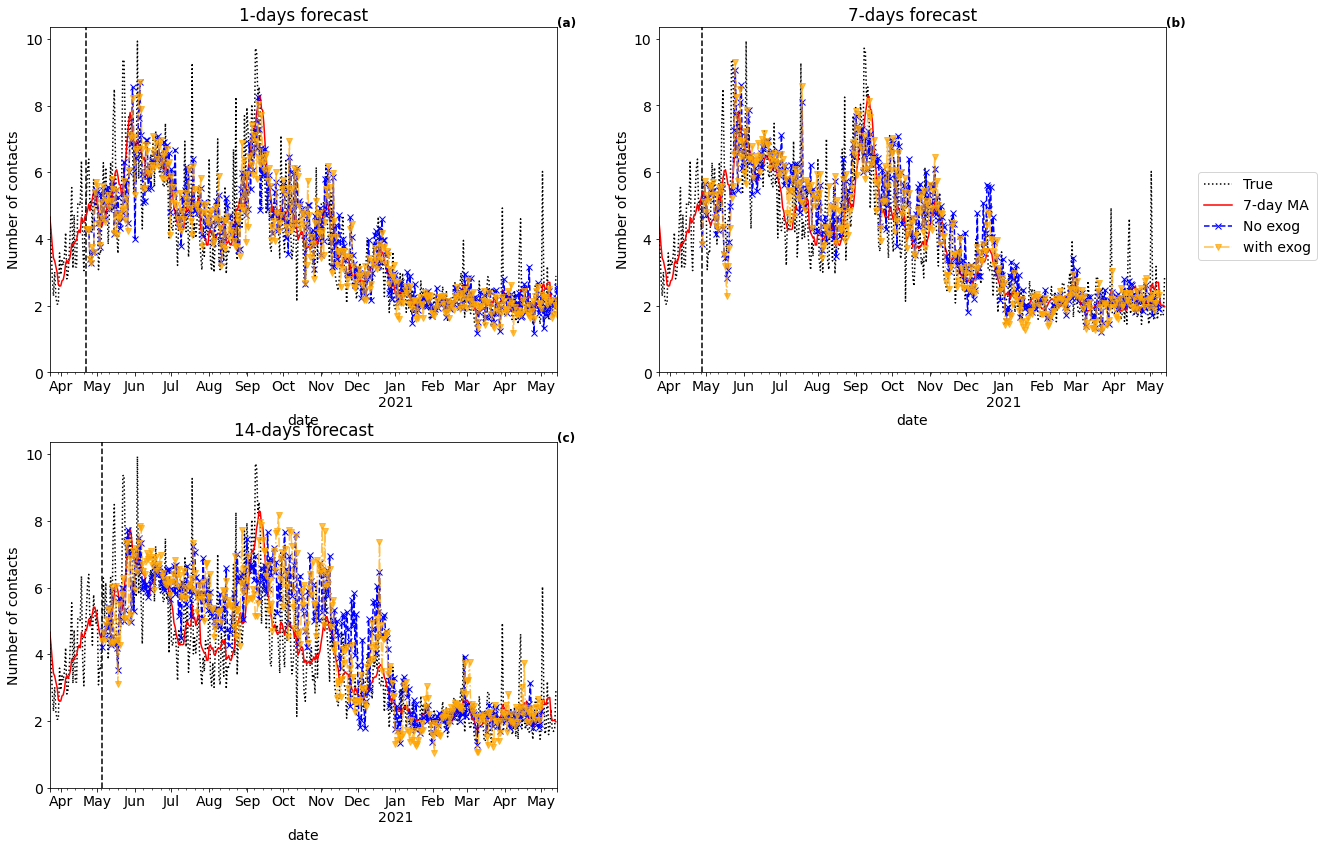

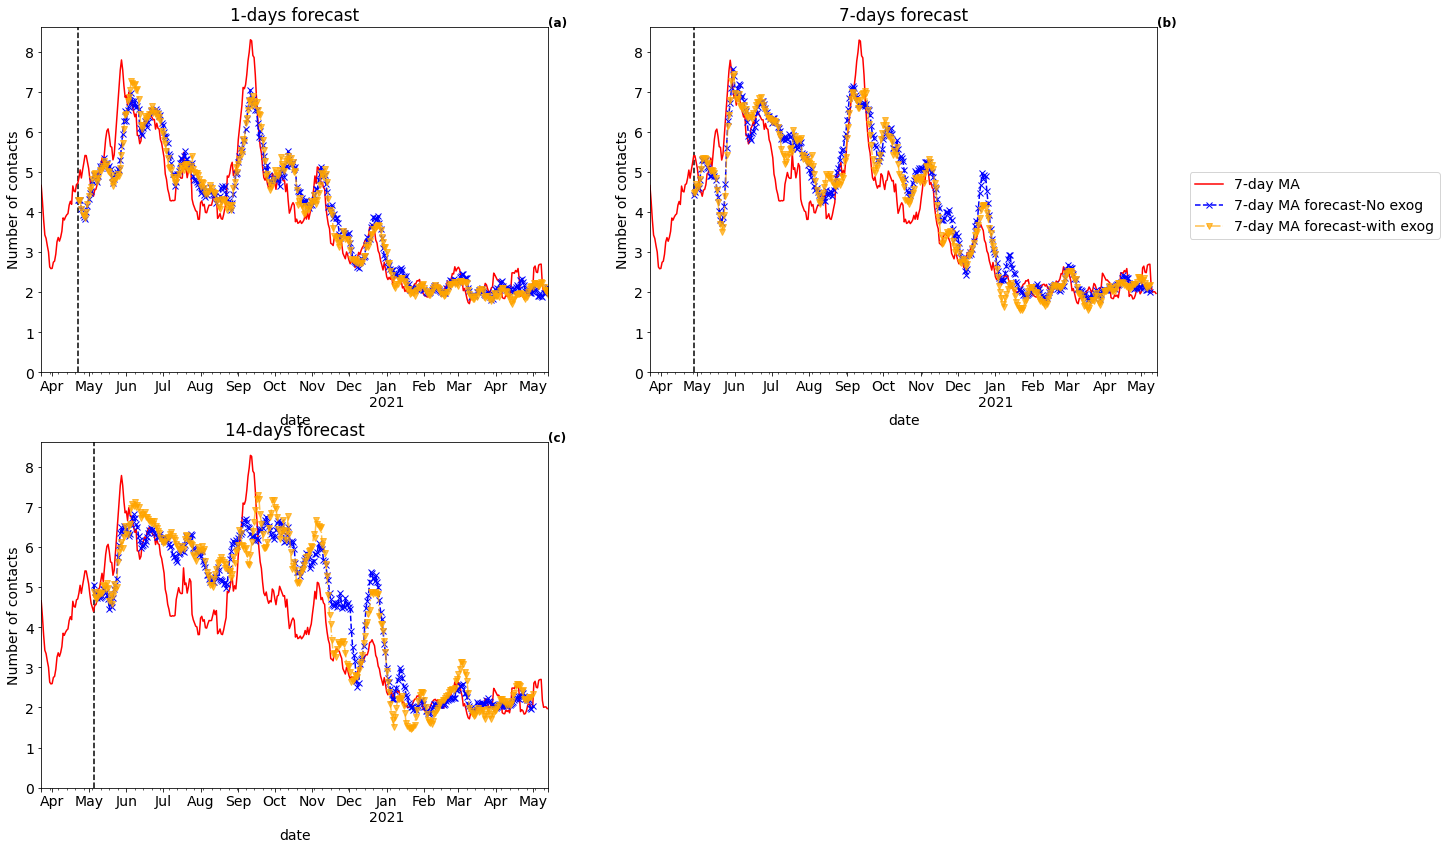

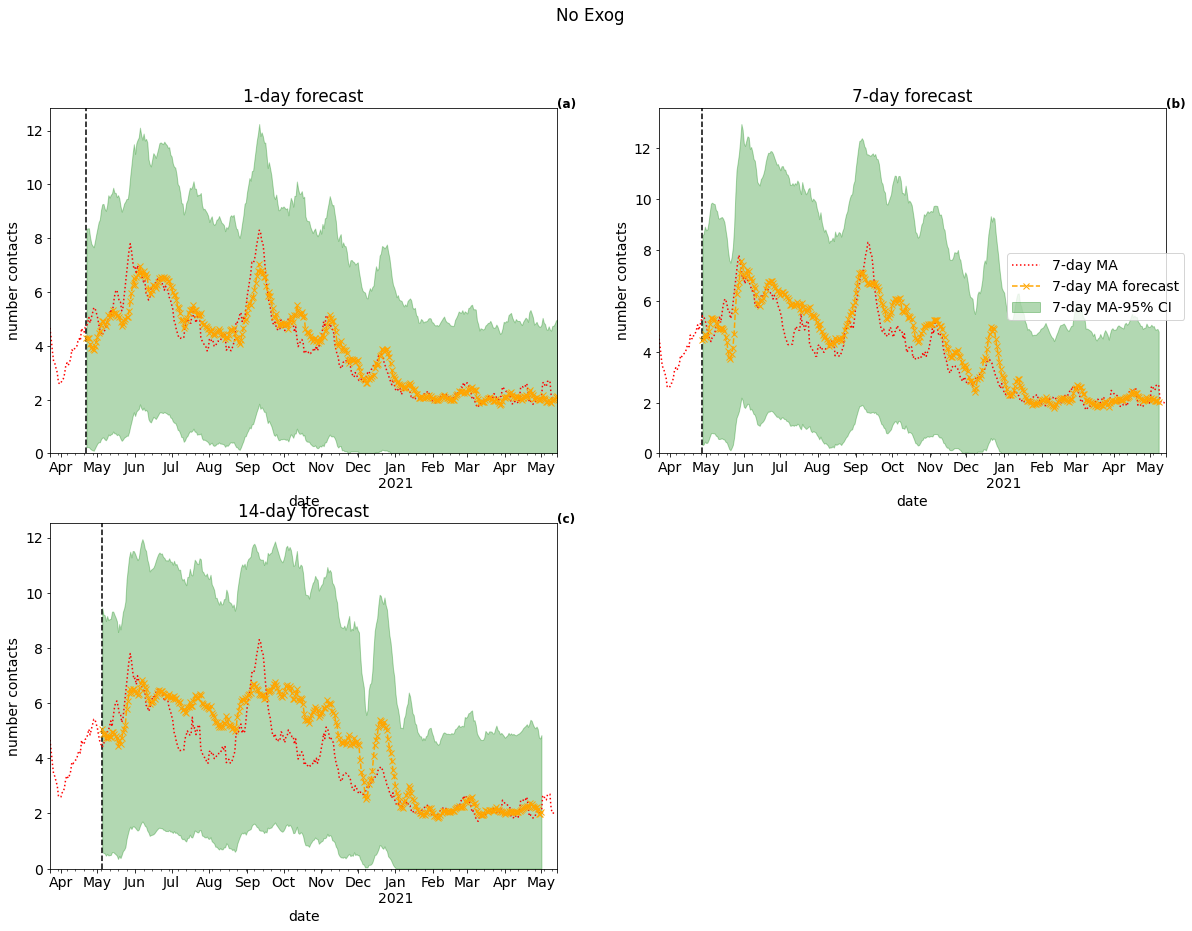

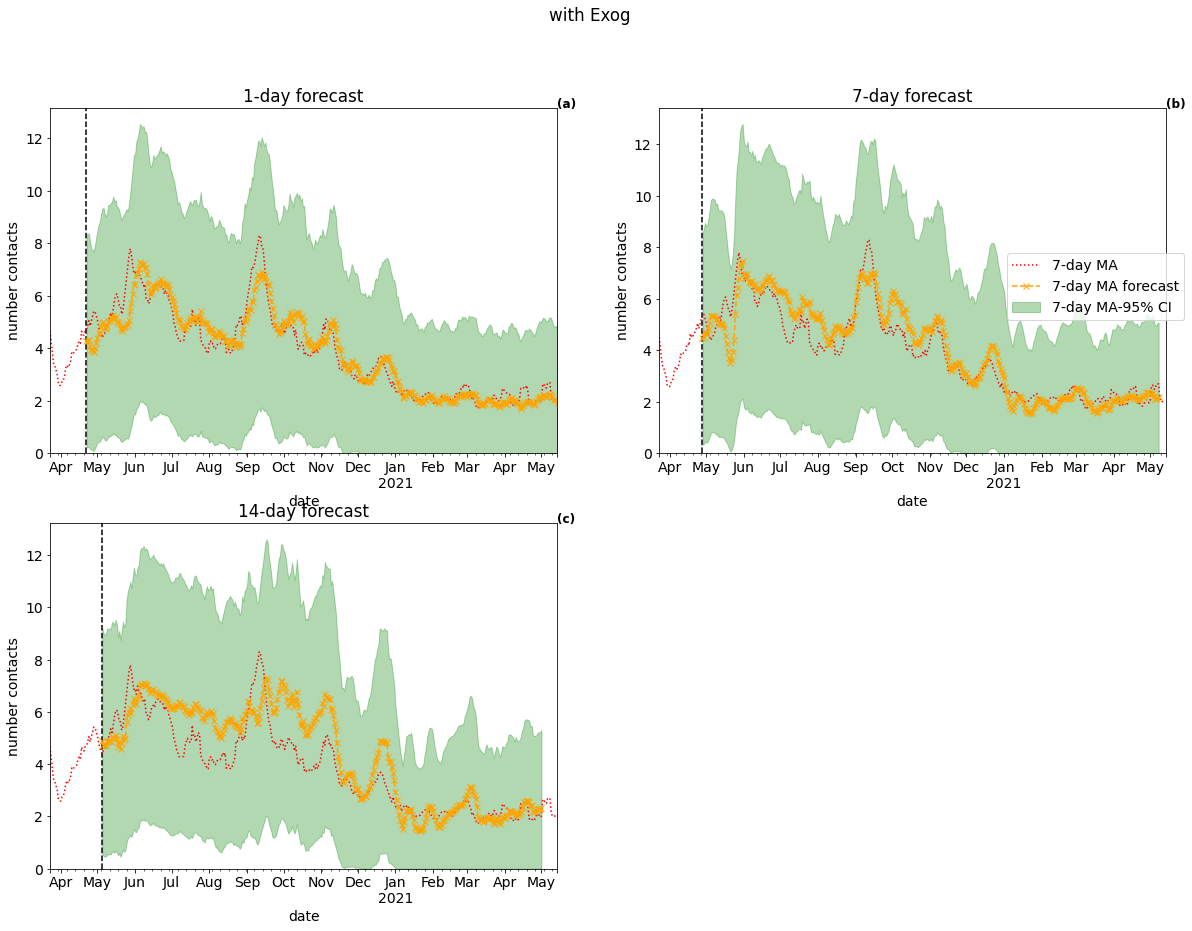

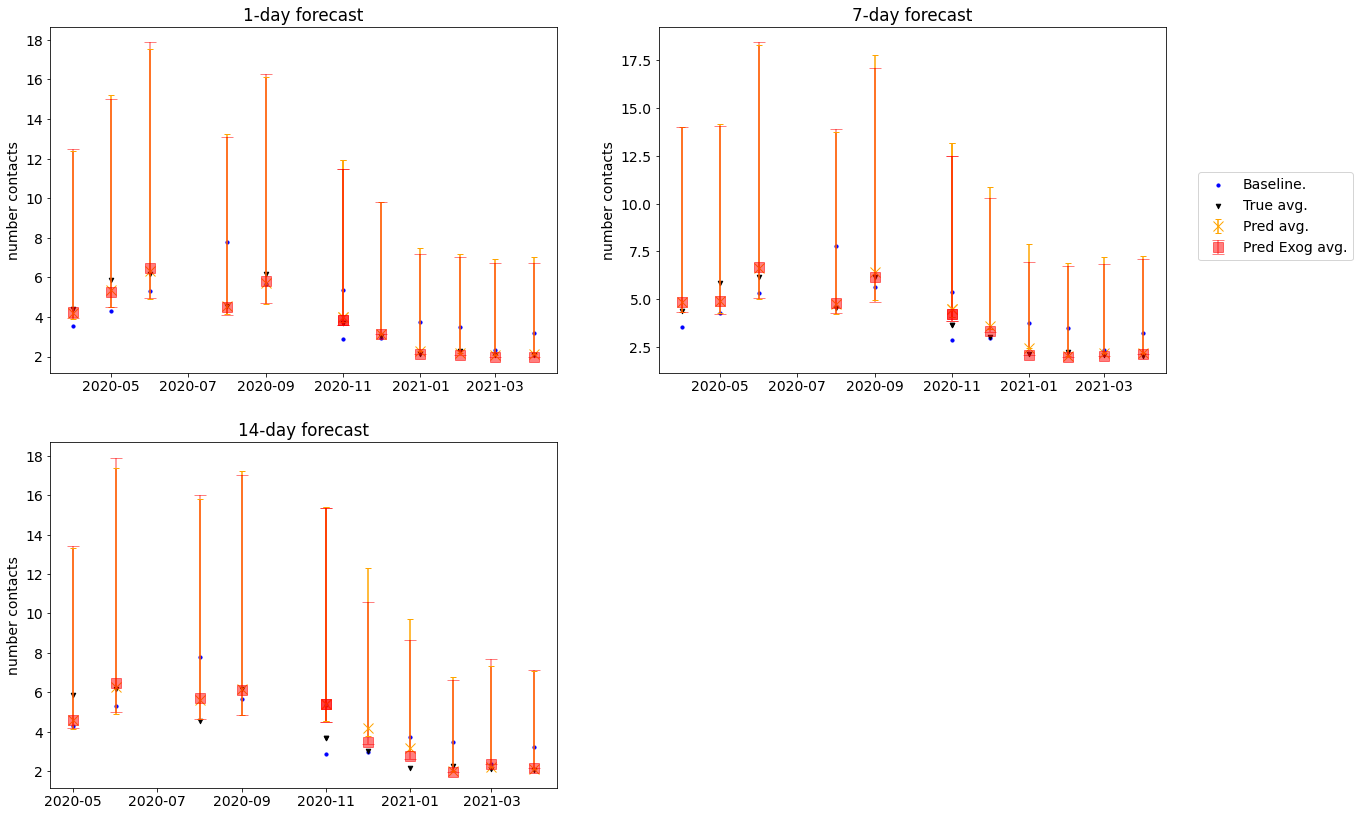

In [65]:
save_predictions(filePath.name+"/total_no_exog.pk", forecast_by_steps, nums= [0, 6, 13])
save_predictions(filePath.name+"/total_exog.pk", forecast_by_steps_exog, nums= [0, 6, 13])
# #
fig, ax= plot_compare(target_col, forecast_by_steps, forecast_by_steps_exog)
plt.savefig(figPath.name+"/total_comp.jpg", dpi=300, bbox_inhex="tight")
#
fig, ax=plot_compare_rolling(target_col, forecast_by_steps, forecast_by_steps_exog)
plt.savefig(figPath.name+"/total_comp_rolling.jpg", dpi=300, bbox_inches="tight")
#
fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps)
fig.suptitle("No Exog")
plt.savefig(figPath.name+"/rolling_7_no_exog.jpg", dpi=300, bbox_inches="tight")
#
fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps_exog)
fig.suptitle("with Exog")
plt.savefig(figPath.name+"/rolling_7_exog.jpg", dpi=300, bbox_inches="tight")
end_train= df.index[0] + datetime.timedelta(days=28)
#
metrics_df= get_metrics(df, forecast_by_steps, forecast_by_steps_exog, target_col)
metrics_df.to_csv(filePath.name+"/metrics.csv")
#
monthly_metrics_df= compare_with_monthly(df, target_col, num_contact, forecast_by_steps, forecast_by_steps_exog)
plt.savefig(figPath.name+"/comp_with_monthly.jpg", dpi=300, bbox_inches="tight")

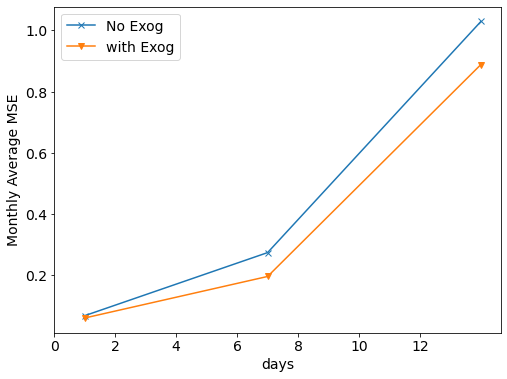

In [66]:
fig, ax= plt.subplots(figsize=(8, 6))
markers=['x', 'v']
monthly_metrics_df.plot(ax=ax, legend=None)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
#
ax.set_ylabel("Monthly Average MSE")
ax.legend(["No Exog", "with Exog"])
_=ax.set_xticks(list(range(14))[::2])
plt.savefig(figPath.name+"/monthly_comp_mse.jpg", dpi=300, bbox_inches="tight")

In [ ]:
def get_metrics_for_all_steps(df, forecast_by_steps, forecast_by_steps_exog, target_col):

    mse=[]
    mse_exog=[]
    one_day= datetime.timedelta(days=1)
     
    for n in range(len(forecast_by_steps)):
        steps= datetime.timedelta(n+1)

        end_date= forecast_by_steps[n].index.to_list()[0]
        mse.append(mean_squared_error(df.loc[end_date-one_day:, target_col].values, forecast_by_steps[n].pred.values))
        mse_exog.append(mean_squared_error(df.loc[end_date-one_day:, target_col].values, forecast_by_steps_exog[n].pred.values))


    metrics_df= pd.DataFrame(index=[n+1 for n in range(len(forecast_by_steps))], data={"MSE":mse, "MSE-exog":mse_exog})
    metrics_df.index.name= "days"
    
    return metrics_df

In [ ]:
all_metrics= get_metrics_for_all_steps(df, forecast_by_steps, forecast_by_steps_exog, target_col)

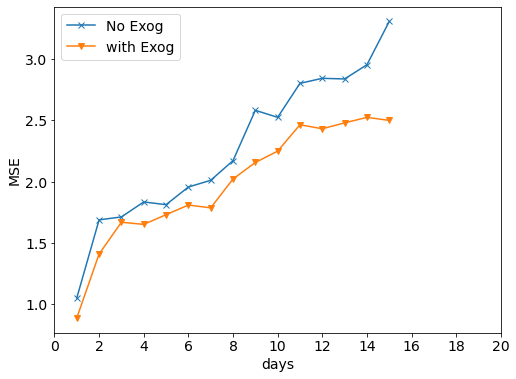

In [ ]:
fig, ax= plt.subplots(figsize=(8, 6))
markers=['x', 'v']
all_metrics.plot(ax=ax, legend=None)
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])
#
ax.set_ylabel("MSE")
ax.legend(["No Exog", "with Exog"])
_=ax.set_xticks(list(range(21))[::2])
plt.savefig(figPath.name+"/comp_mse.jpg", dpi=300, bbox_inches="tight")

In [ ]:
!zip -r figs.zip figs

  adding: figs/ (stored 0%)
  adding: figs/monthly_comp_mse.jpg (deflated 38%)
  adding: figs/rolling_7_exog.jpg (deflated 26%)
  adding: figs/total_comp_rolling.jpg (deflated 22%)
  adding: figs/comp_with_monthly.jpg (deflated 51%)
  adding: figs/rolling_7_no_exog.jpg (deflated 25%)
  adding: figs/comp_mse.jpg (deflated 37%)
  adding: figs/total_comp.jpg (deflated 16%)


In [ ]:
from google.colab import files
files.download("/content/figs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>